In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR as AR
from statsmodels.tsa.ar_model import ARResults as ARResults
from statsmodels.tsa.arima_model import ARMAResults as ARMAResults
from statsmodels.tsa.arima_model import ARMA as ARMA
from statsmodels.tsa.arima_model import ARIMAResults as ARIMAResults
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from pyramid.arima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

%pylab inline
%matplotlib inline

plt.style.use('ggplot')

plt.rcParams['figure.figsize'] = (14, 7)

Populating the interactive namespace from numpy and matplotlib


In [52]:
df = pd.read_csv('realestate-loans-billions-monthl.csv', sep=',')
#df = pd.read_csv('average-amount-financed-for-new-.csv', sep=',')

In [53]:
df.head()

,Month,Real-estate loans (billions) (monthly: Jan.1973-Oct.1978)
0,1973-01,46.5
1,1973-02,47.0
2,1973-03,47.5
3,1973-04,48.3
4,1973-05,49.1


In [54]:
df = df.drop(df.index[len(df)-1])

In [55]:
df.columns = ['Month', 'Loans']
#df.Year = pd.to_datetime(df['Month'], format='%Y%m')
df.set_index('Month', inplace=True)
df.head()

,Loans
Month,
1973-01,46.5
1973-02,47.0
1973-03,47.5
1973-04,48.3
1973-05,49.1


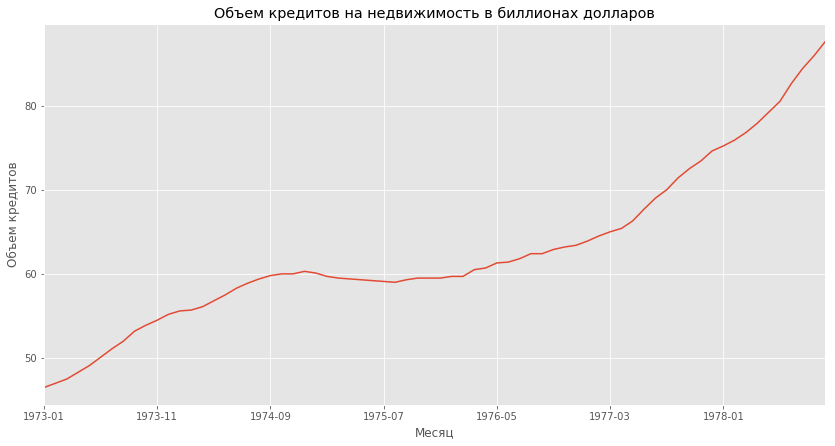

In [56]:
df.Loans.plot()
plt.title('Объем кредитов на недвижимость в биллионах долларов')
plt.xlabel('Месяц')
plt.ylabel('Объем кредитов')

### Задание 1

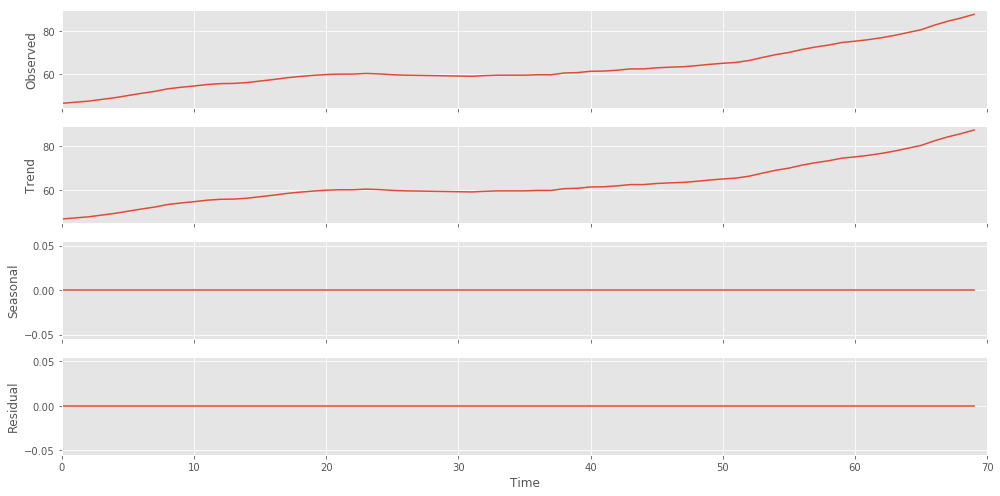

In [58]:
fig = sm.tsa.seasonal_decompose(df.Loans.values, freq=1).plot()
#print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Members)[1])
savefig('hw3_stl.png')

In [60]:
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Loans)[1])

Критерий Дики-Фуллера: p=0.996405


In [61]:
x = np.array(df['Loans'])
n = len(df)
def getInvCount(arr, n):
    inv_count = 0
    for i in range(n):
        for j in range(i+1, n):
            if (arr[i] > arr[j]):
                inv_count += 1
    
    return inv_count
I = getInvCount(x,n)
stat = (I - ((n*(n-1))/4))/(math.sqrt((2*n**3 + 3*n**2 - 5*n)/72))
print('Результаты применения критерия инверсий', 'Длина ряда:', n,
      'Количество инверсий:', I, 'Значение статистики:', stat, sep='\n')

Результаты применения критерия инверсий
Длина ряда:
70
Количество инверсий:
98
Значение статистики:
-11.249571705990228


In [62]:
n = len(df)
new_row = []
x = df.Loans
for i in range(n):
    y = x[i] - x[i-1]
    new_row.append(y)
    
#len(new_row)
df_new = df
for i in range(n):
    df_new['Loans'][i] = new_row[i]
df_new.head()

,Loans
Month,
1973-01,-41.1
1973-02,0.5
1973-03,0.5
1973-04,0.8
1973-05,0.8


In [68]:
n = len(df_new)
new_row = []
x = df_new.Loans
for i in range(n):
    y = x[i] - x[i-1]
    new_row.append(y)
    
#len(new_row)
df2 = df_new
for i in range(n):
    df2['Loans'][i] = new_row[i]
df2.head()

,Loans
Month,
1973-02,-1.200000e+00
1973-03,0.000000e+00
1973-04,3.000000e-01
1973-05,7.105427e-15
1973-06,2.000000e-01


In [66]:
df_new = df_new.drop(df_new.index[0])

Критерий Дики-Фуллера: p=0.000000


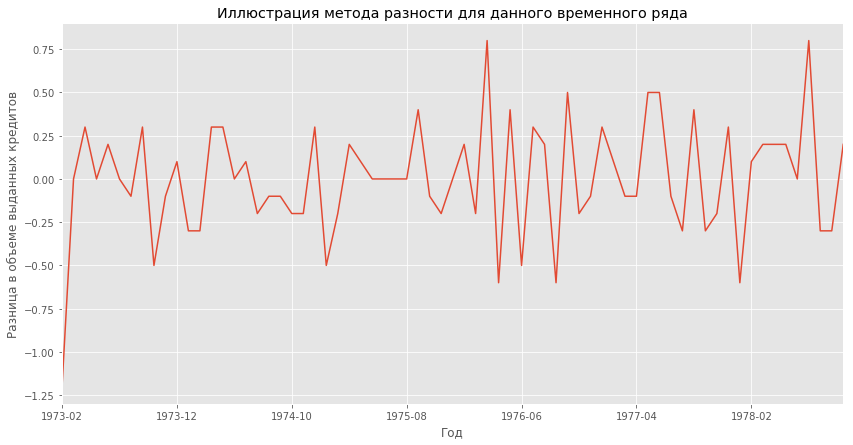

In [69]:
df_new.Loans.plot()
plt.title('Иллюстрация метода разности для данного временного ряда')
plt.xlabel('Год')
plt.ylabel('Разница в объеме выданных кредитов')
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df_new.Loans)[1])

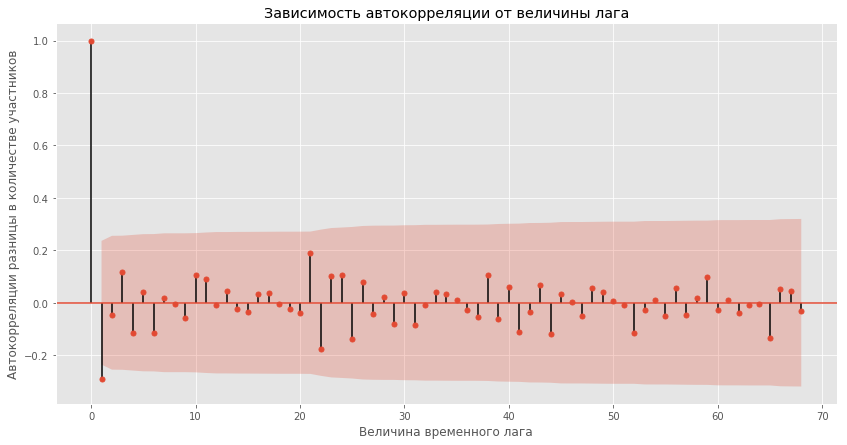

In [71]:
sm.graphics.tsa.plot_acf(df2.Loans.values.squeeze())
plt.title('Зависимость автокорреляции от величины лага')
plt.xlabel('Величина временного лага')
plt.ylabel('Автокорреляции разницы в количестве участников')
#print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Members)[1])
savefig('acf.png')

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


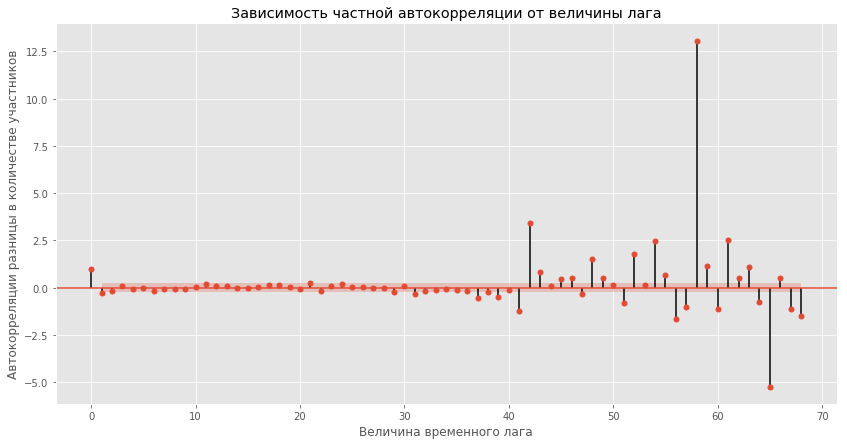

In [72]:
sm.graphics.tsa.plot_pacf(df2.Loans.values.squeeze())
plt.title('Зависимость частной автокорреляции от величины лага')
plt.xlabel('Величина временного лага')
plt.ylabel('Автокорреляции разницы в количестве участников')
#print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.Members)[1])
savefig('pacf.png')

In [73]:
print('Автокорреляция первого порядка:', sm.tsa.stattools.acf(df2.Loans.values, nlags=1)[1], 
      'Частная автокорреляция первого порядка:', sm.tsa.stattools.pacf(df2.Loans, nlags=1)[1], sep='\n')

Автокорреляция первого порядка:
-0.291560102302
Частная автокорреляция первого порядка:
-0.295847750865


In [74]:
armafit = ARMA(endog=df2.Loans.values, order=(2, 2)).fit()
y_pred_arma = armafit.predict()
print(armafit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   69
Model:                     ARMA(2, 2)   Log Likelihood                 -17.365
Method:                       css-mle   S.D. of innovations              0.311
Date:                Mon, 11 Jun 2018   AIC                             46.729
Time:                        23:09:05   BIC                             60.134
Sample:                             0   HQIC                            52.047
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0056      0.024      0.231      0.818      -0.042       0.053
ar.L1.y       -0.9631      0.371     -2.596      0.012      -1.690      -0.236
ar.L2.y       -0.2980      0.365     -0.816      0.4

In [76]:
armafit = ARMA(endog=df2.Loans.values, order=(1, 2)).fit()
y_pred_arma = armafit.predict()
print(armafit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   69
Model:                     ARMA(1, 2)   Log Likelihood                 -17.615
Method:                       css-mle   S.D. of innovations              0.312
Date:                Mon, 11 Jun 2018   AIC                             45.230
Time:                        23:09:16   BIC                             56.401
Sample:                             0   HQIC                            49.662
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.021      0.312      0.756      -0.035       0.049
ar.L1.y       -0.8048      0.203     -3.969      0.000      -1.202      -0.407
ma.L1.y        0.4261      0.213      2.001      0.0

In [77]:
armafit = ARMA(endog=df2.Loans.values, order=(2, 1)).fit()
y_pred_arma = armafit.predict()
print(armafit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   69
Model:                     ARMA(2, 1)   Log Likelihood                 -17.412
Method:                       css-mle   S.D. of innovations              0.311
Date:                Mon, 11 Jun 2018   AIC                             44.824
Time:                        23:09:23   BIC                             55.995
Sample:                             0   HQIC                            49.256
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0049      0.025      0.195      0.846      -0.044       0.054
ar.L1.y       -0.9785      0.402     -2.432      0.018      -1.767      -0.190
ar.L2.y       -0.3900      0.145     -2.697      0.0

In [82]:
armafit = ARMA(endog=df2.Loans.values, order=(1, 1)).fit()
y_pred_arma = armafit.predict(end = (len(df) + 10))
print(armafit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   69
Model:                     ARMA(1, 1)   Log Likelihood                 -18.116
Method:                       css-mle   S.D. of innovations              0.314
Date:                Mon, 11 Jun 2018   AIC                             44.232
Time:                        23:23:40   BIC                             53.168
Sample:                             0   HQIC                            47.777
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0066      0.022      0.299      0.766      -0.037       0.050
ar.L1.y        0.0034      0.362      0.009      0.993      -0.706       0.713
ma.L1.y       -0.4257      0.330     -1.291      0.2

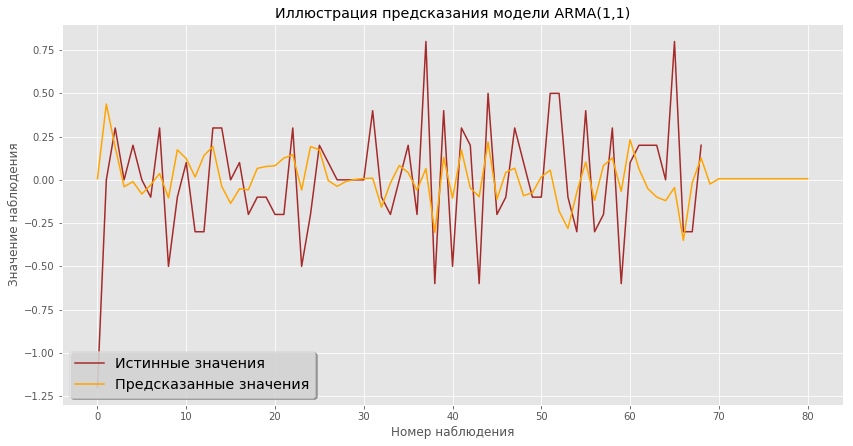

In [83]:
plt.plot(df2.Loans.values, color='brown', label='Истинные значения')
plt.plot(y_pred_arma, color='orange', label='Предсказанные значения')
plt.legend(loc='lower left', shadow=True, fontsize='x-large')
plt.title('Иллюстрация предсказания модели ARMA(1,1)')
plt.xlabel('Номер наблюдения')
plt.ylabel('Значение наблюдения')

In [84]:
data = pd.read_excel('datatimeseries.xlsx')

In [87]:
data.to_csv('data.csv')

In [88]:
data = pd.read_csv('data.csv')

In [89]:
data.head()

,Unnamed: 0,Month,Realestate,Newcars,InterestRates
0,0,1973-01,46.5,3200,6.46
1,1,1973-02,47.0,3199,6.64
2,2,1973-03,47.5,3184,6.71
3,3,1973-04,48.3,3201,6.67
4,4,1973-05,49.1,3225,6.85
